# Classificação de textos

Classificação de textos é uma atividade que consiste em categorizar um texto em categorias pré-definidas. Existem várias aplicações, como: classificação de spam, classificação de notícias em categorias, identificação de características de autores, análise de sentimento, etc.

Em geral, o processo de classificação envolve um modelo de aprendizado de máquina, sendo constituido em duas etapas:
1. Os textos usados para treino do modelo são representados de alguma forma.
2. O treino do modelo em si é realizado.

Para modelos de classificação de texto, geralmente usamos o paradigma de aprendizado supervisionado, isso é, as categorias de classificação já são conhecidas.

# 1. Classificação de comentários da Amazon

Usando uma base de dados da Amazon vamos criarum modelo de classificação binária de comentários. O modelo classificará os comentários sobre um produto como positivo ou negativo.

## 1.1 Importação e análise exploratória

In [ ]:
# Importando dados
!wget https://raw.githubusercontent.com/adalves-ufabc/2021.Q3-PLN/main/Aula%2013/dados/corpus.csv

--2021-11-18 02:47:50--  https://raw.githubusercontent.com/adalves-ufabc/2021.Q3-PLN/main/Aula%2013/dados/corpus.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4529936 (4.3M) [text/plain]
Saving to: ‘corpus.csv’

corpus.csv          100%[===================>]   4.32M  --.-KB/s    in 0.06s   

2021-11-18 02:47:51 (72.4 MB/s) - ‘corpus.csv’ saved [4529936/4529936]



In [ ]:
# Importando a pandas
import pandas as pd

In [ ]:
# Criando dataframe com base no csv
comentarios = pd.read_csv("corpus.csv", encoding='latin-1')

In [ ]:
# Visualizando 5 primeiras linhas da tabela
comentarios.head()

,text,label
0,Stuning even for the non-gamer: This sound tr...,positive
1,The best soundtrack ever to anything.: I'm re...,positive
2,Amazing!: This soundtrack is my favorite musi...,positive
3,Excellent Soundtrack: I truly like this sound...,positive
4,"Remember, Pull Your Jaw Off The Floor After H...",positive


In [ ]:
# Visualizando 5 últimas linhas da tabela
comentarios.tail()

,text,label
9995,A revelation of life in small town America in...,positive
9996,Great biography of a very interesting journal...,positive
9997,Interesting Subject; Poor Presentation: You'd...,negative
9998,Don't buy: The box looked used and it is obvi...,negative
9999,Beautiful Pen and Fast Delivery.: The pen was...,positive


In [ ]:
# Importando a seaborn
import seaborn as sns

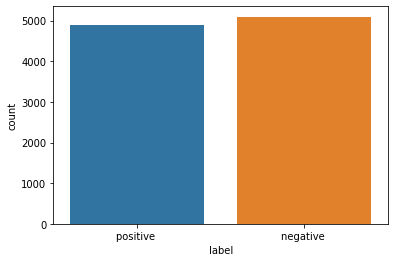

In [ ]:
# Contagem de cada tipo de comentário
sns.countplot(x="label",data=comentarios)

In [ ]:
# Vamos criar uma coluna que mostra o tamanho de cada documento (comentário)
comentarios["tam"] = comentarios["text"].str.len()
comentarios.head()

,text,label,tam
0,Stuning even for the non-gamer: This sound tr...,positive,428
1,The best soundtrack ever to anything.: I'm re...,positive,510
2,Amazing!: This soundtrack is my favorite musi...,positive,761
3,Excellent Soundtrack: I truly like this sound...,positive,744
4,"Remember, Pull Your Jaw Off The Floor After H...",positive,482


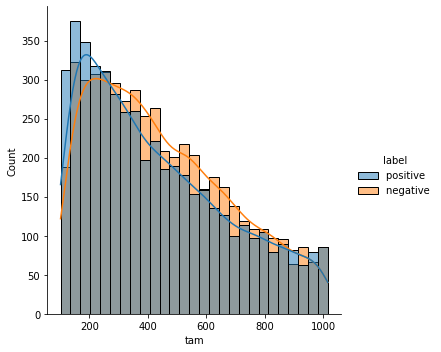

In [ ]:
# Vamos visualizar a distribuição de tamanhos através de um histograma
sns.color_palette("Set2")
sns.displot(data=comentarios, x="tam", hue="label", kind="hist", kde=True)

Podemos ver que as distribuições são bem parecidas.

## 1.2 Pré-processamento

In [ ]:
# Importando a nltk e alguns corpus que serão úteis nos processos de limpeza, tokenização e lemmatização
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Criando função de limpeza, remoção de stopwords e redução a stem/lemma
def pre_processamento(texto, reducao = None):
  # Tokenização
  tokens = wordpunct_tokenize(texto) 
  # Conversão para minúsculo
  tokens = [token.lower() for token in tokens]
  # Remoção de stopwords
  sws = stopwords.words('english')
  tokens = [token for token in tokens if token not in sws]
  # Remoção de pontuação
  tokens = [token for token in tokens if token not in string.punctuation]
  if reducao == 'lemmatizer':
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(token) for token in tokens] 
  elif reducao == 'stemmer':
    stm = PorterStemmer()
    tokens = [stm.stem(word = token) for token in tokens]
  return tokens

In [ ]:
# Vamos usar a nossa nova função para criar duas novas colunas, uma com os lemmas e outra com os stems
comentarios['stems'] = [pre_processamento(texto,reducao='stemmer') for texto in comentarios['text']]
comentarios['lemmas'] = [pre_processamento(texto,reducao='lemmatizer') for texto in comentarios['text']]

In [ ]:
# Visualizando novas colunas
comentarios.head()

,text,label,tam,stems,lemmas
0,Stuning even for the non-gamer: This sound tr...,positive,428,"[stune, even, non, gamer, sound, track, beauti...","[stuning, even, non, gamer, sound, track, beau..."
1,The best soundtrack ever to anything.: I'm re...,positive,510,"[best, soundtrack, ever, anyth, .:, read, lot,...","[best, soundtrack, ever, anything, .:, reading..."
2,Amazing!: This soundtrack is my favorite musi...,positive,761,"[amaz, !:, soundtrack, favorit, music, time, h...","[amazing, !:, soundtrack, favorite, music, tim..."
3,Excellent Soundtrack: I truly like this sound...,positive,744,"[excel, soundtrack, truli, like, soundtrack, e...","[excellent, soundtrack, truly, like, soundtrac..."
4,"Remember, Pull Your Jaw Off The Floor After H...",positive,482,"[rememb, pull, jaw, floor, hear, play, game, k...","[remember, pull, jaw, floor, hearing, played, ..."


## 1.3 Análise qualitativa com nuvens de palavras


In [ ]:
# Importação de pacotes de visualização de nuvens
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [ ]:
# Definindo função para gerar nuvem de palavras
def nuvem_palavras(texto, titulo, tam = 50):
  # Calculando frequência de cada termo
  freqs = Counter(token for documento in texto for token in set(documento))
  # Gerando nuvem de palavras
  wc = WordCloud()
  wc.generate_from_frequencies(dict(freqs.most_common(tam)))
  # Plotando nuvem de palavras
  plt.figure()
  plt.imshow(wc, interpolation="bilinear")
  plt.title(titulo)
  plt.axis("off")
  plt.show()

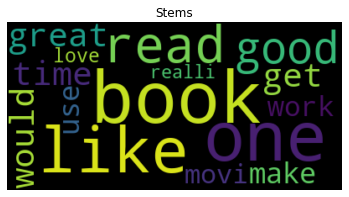

In [ ]:
# Geração para coluna stems
nuvem_palavras(comentarios['stems'],"Stems", 15)

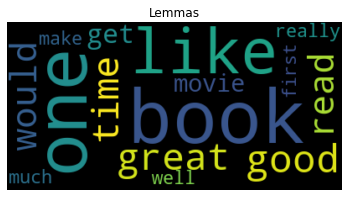

In [ ]:
# Geração para coluna lemma
nuvem_palavras(comentarios['lemmas'],"Lemmas", 15)

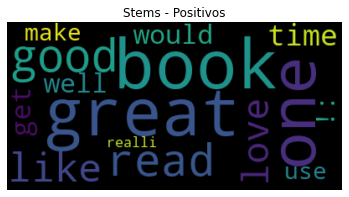

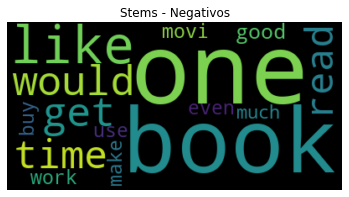

In [ ]:
# Vendo quais os stems mais frequentes em comentários positivos e negativos
nuvem_palavras(comentarios['stems'][comentarios['label'].str.match('positive')],"Stems - Positivos", 15)
nuvem_palavras(comentarios['stems'][comentarios['label'].str.match('negative')],"Stems - Negativos", 15)

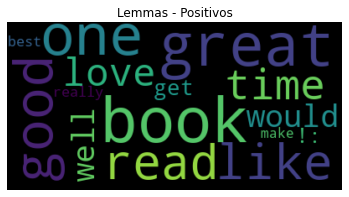

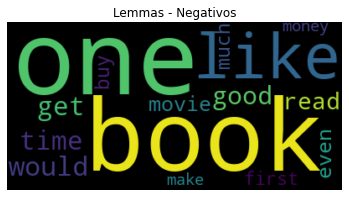

In [ ]:
# Vendo quais os lemmas mais frequentes em comentários positivos e negativos
nuvem_palavras(comentarios['lemmas'][comentarios['label'].str.match('positive')],"Lemmas - Positivos", 15)
nuvem_palavras(comentarios['lemmas'][comentarios['label'].str.match('negative')],"Lemmas - Negativos", 15)

## 1.4 Realização de divisão treino-teste da base

In [ ]:
# Vamos realizar o splitting 70-30, ou seja, 70% da nossa base será usada para treino do modelo e 30% para teste do modelo
# Vamos começar importando o módulo necessário do scikit-learn e depois realizando o splitting
from sklearn.model_selection import train_test_split
train_comentarios, test_comentarios =  train_test_split(comentarios, test_size=0.3, random_state=0)

In [ ]:
# Visualizando base de treino
train_comentarios.head()

,text,label,tam,stems,lemmas
7681,Laminator Plus: I was really disappointed to ...,negative,359,"[lamin, plu, realli, disappoint, find, pad, tw...","[laminator, plus, really, disappointed, find, ..."
9031,"Crocodile Doom: The product is flaky, fragile...",negative,268,"[crocodil, doom, product, flaki, fragil, small...","[crocodile, doom, product, flaky, fragile, sma..."
3691,"Show=Amazing , DVD=RUSHED: One of my favorite...",negative,443,"[show, amaz, dvd, rush, one, favorit, show, ev...","[show, amazing, dvd, rushed, one, favorite, sh..."
202,False Advertisement: The pillow I received is...,negative,495,"[fals, advertis, pillow, receiv, noth, like, o...","[false, advertisement, pillow, received, nothi..."
5625,Poor Information for Celiacs: I found areas o...,negative,394,"[poor, inform, celiac, found, area, book, cont...","[poor, information, celiacs, found, area, book..."


In [ ]:
# Visualizando base de teste
test_comentarios.head()

,text,label,tam,stems,lemmas
9394,This is not the screenplay: This is the scrip...,negative,175,"[screenplay, script, stage, play, updat, moder...","[screenplay, script, stage, play, updated, mod..."
898,One of the Greatest Books Ever Written: The S...,positive,798,"[one, greatest, book, ever, written, scarlet, ...","[one, greatest, book, ever, written, scarlet, ..."
2398,Ok but nothing great: Its not a bad book but ...,negative,452,"[ok, noth, great, bad, book, expect, didnt, fi...","[ok, nothing, great, bad, book, expected, didn..."
5906,Doesn't work: I was looking forward to using ...,negative,364,"[work, look, forward, use, canon, powershot, m...","[work, looking, forward, using, canon, powersh..."
2343,Not so hidden fantasies explored and discover...,positive,1003,"[hidden, fantasi, explor, discov, ...:, writte...","[hidden, fantasy, explored, discovered, ...:, ..."


## 1.5 Representação dos stems através de TF-IDF

In [ ]:
# Importando pacote de vetorização através do TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Criando objeto vetorizador
vetorizador = TfidfVectorizer()

In [ ]:
# Criando representação das colunas de stems e lemmas para treino e teste dos modelos
# Veja que usamos as funções fit_transform e transform
# Não usamos a fit_transform para o df de teste porque precisamos usar o mesmo vocabulário do df de treino

train_stems = vetorizador.fit_transform([" ".join(texto) for texto in train_comentarios['stems']])
test_stems = vetorizador.transform([" ".join(texto) for texto in test_comentarios['stems']])

train_lemmas = vetorizador.fit_transform([" ".join(texto) for texto in train_comentarios['lemmas']])
test_lemmas = vetorizador.transform([" ".join(texto) for texto in test_comentarios['lemmas']])

## 1.6 Comparando modelos usando SVM, RegLog e Naive-Bayes

In [ ]:
# Importando os 3 algoritmos que serão usados na comparação
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Importando a métrica de acurácia, que será referência na comparação
from sklearn.metrics import accuracy_score

In [ ]:
# Criando dicionário com nomes para chamarmos os diferentes algoritmos mais facilmente
algoritmos = {'SVM' : LinearSVC(),'Regressão Logística' : LogisticRegression(), 'Naive Bayes': GaussianNB()}

In [ ]:
# Criação de modelos e realização de testes para os três algoritmos com stems
for nome, alg in algoritmos.items():
    alg.fit(train_stems.toarray(),train_comentarios['label'])
    predicoes = alg.predict(test_stems.toarray())
    print(f"Acurácia média com stemming e o algoritmo {nome} {accuracy_score(test_comentarios['label'],predicoes)*100:.2f}%")

Acurácia média com stemming e o algoritmo SVM 85.27%
Acurácia média com stemming e o algoritmo Regressão Logística 86.33%
Acurácia média com stemming e o algoritmo Naive Bayes 62.33%


In [ ]:
# Criação de modelos e realização de testes para os três algoritmos com lemmas
for nome, alg in algoritmos.items():
    alg.fit(train_lemmas.toarray(),train_comentarios['label'])
    predicoes = alg.predict(test_lemmas.toarray())
    print(f"Acurácia média com stemming e o algoritmo {nome} {accuracy_score(test_comentarios['label'],predicoes)*100:.2f}%")

Acurácia média com stemming e o algoritmo SVM 86.27%
Acurácia média com stemming e o algoritmo Regressão Logística 86.77%
Acurácia média com stemming e o algoritmo Naive Bayes 65.77%


# 2. Detecção de spams

Usando uma base de dados de emails, vamos criar um modelo classificador de textos para classificar se um texto é spam ou não.

## 2.1 Importando a base de dados e bibliotecas

In [ ]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
# Importando base de dados
!wget https://raw.githubusercontent.com/adalves-ufabc/2021.Q3-PLN/main/Aula%2013/dados/spam.csv
df = pd.read_csv('spam.csv',encoding='latin-1')

--2021-11-19 10:50:58--  https://raw.githubusercontent.com/adalves-ufabc/2021.Q3-PLN/main/Aula%2013/dados/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.01s   

2021-11-19 10:50:58 (34.1 MB/s) - ‘spam.csv’ saved [503663/503663]



## 2.2 Análise exploratória

In [ ]:
# Dimensões do dataframe
df.shape

(5572, 5)

In [ ]:
# Visualizando dados
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Visualizando dados
df.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [ ]:
# Visualizando valores únicos da terceira coluna
df["Unnamed: 2"].unique()

array([nan, ' PO Box 5249',
       ' the person is definitely special for u..... But if the person is so special',
       ' HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE JEN XXX\\""',
       ' wanted to say hi. HI!!!\\" Stop? Send STOP to 62468"',
       'this wont even start........ Datz confidence.."', 'GN',
       '.;-):-D"',
       'just been in bedbut mite go 2 thepub l8tr if uwana mt up?loads a luv Jenxxx.\\""',
       ' bt not his girlfrnd... G o o d n i g h t . . .@"',
       ' I\'ll come up"',
       ' don\'t miss ur best life for anything... Gud nyt..."',
       ' just as a shop has to give a guarantee on what they sell. B. G."',
       ' But at d end my love compromised me for everything:-(\\".. Gud mornin:-)"',
       ' the toughest is acting Happy with all unspoken pain inside..\\""',
       ' smoke hella weed\\""', '\\" not \\"what i need to do.\\""',
       'JUST GOT PAYED2DAY & I HAVBEEN GIVEN Aå£50 PAY RISE 4MY WORK & HAVEBEEN MADE PRESCHOOLCO-ORDINATOR 2I AM FEELINGOOD

In [ ]:
# Visualizando valores únicos da quarta coluna
df["Unnamed: 3"].unique()

array([nan, ' MK17 92H. 450Ppw 16"', ' why to miss them', 'GE',
       'U NO THECD ISV.IMPORTANT TOME 4 2MORO\\""',
       'i wil tolerat.bcs ur my someone..... But',
       ' ILLSPEAK 2 U2MORO WEN IM NOT ASLEEP...\\""',
       'whoever is the KING\\"!... Gud nyt"', ' TX 4 FONIN HON',
       ' \\"OH No! COMPETITION\\". Who knew', 'IåÕL CALL U\\""'],
      dtype=object)

In [ ]:
# Visualizando valores únicos da quinta coluna
df["Unnamed: 4"].unique()

array([nan, ' just Keep-in-touch\\" gdeve.."', 'GNT:-)"',
       ' Never comfort me with a lie\\" gud ni8 and sweet dreams"',
       ' CALL 2MWEN IM BK FRMCLOUD 9! J X\\""',
       ' one day these two will become FREINDS FOREVER!"'], dtype=object)

In [ ]:
# Examinando a distribuição de labels
df.v1.value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

## 2.3 Remodelando dataframe

In [ ]:
# Renomeando os nomes das colunas
df = df.rename(columns = {'v1':'label', 'v2':'message'})

In [ ]:
# Adicionando coluna binária de codificação hot-encoding
df['label_bin']=df['label'].map({'ham':0,'spam':1})

In [ ]:
# Visualizando dataframe criado
df.head()

,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4,label_bin
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,0
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,1
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,0


## 2.4 Dados de treino e teste

In [ ]:
# Separando feature e label
label = df['label_bin']
feature = df['message']

In [ ]:
# Importando módulo do scikit-learn
from sklearn.model_selection import train_test_split

In [ ]:
# Separando em teste e treino
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.25, random_state=1)

In [ ]:
# Verificando dimensões
print(label.shape)
print(y_train.shape)
print(y_test.shape)

(5572,)
(4179,)
(1393,)


## 2.5 Vetorizando os dados

In [ ]:
# Importando o vetorizador
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Criando objeto vetorizador
vet = CountVectorizer()

In [ ]:
# Transformando o conjunto de features de treino numa matriz de termos (representação numérica dos textos)
# Como é o conjunto de treino também realizamos o fit
x_train_rep = vet.fit_transform(x_train)
x_train_rep

<4179x7496 sparse matrix of type '<class 'numpy.int64'>'
	with 55614 stored elements in Compressed Sparse Row format>

In [ ]:
# Transformando o conjunto de features de teste numa matriz de termos (representação numérica dos textos)
# Como é o conjunto de teste não realizamos o fit
x_test_rep = vet.transform(x_test)
x_test_rep

<1393x7496 sparse matrix of type '<class 'numpy.int64'>'
	with 17010 stored elements in Compressed Sparse Row format>

## 2.6 Classificador Naive-Bayes e suas métricas

In [ ]:
# Importando Naive Bayes e métrica que usaremos
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [ ]:
# Criando objeto algoritmo de treino
nb = MultinomialNB()

In [ ]:
# Treinando modelo
nb.fit(x_train_rep, y_train)

MultinomialNB()

In [ ]:
# Realizando predição para conjunto de teste
y_pred = nb.predict(x_test_rep)

In [ ]:
# Calculando acurácia
metrics.accuracy_score(y_test,y_pred)

0.9856424982053122

In [ ]:
# Calculando f-value
metrics.f1_score(y_test,y_pred)

0.9438202247191012

In [ ]:
# Matriz de confusão
metrics.confusion_matrix(y_test,y_pred)

array([[1205,    8],
       [  12,  168]])

## 2.7 Classificações erradas

In [ ]:
# Visualizando falsos positivos
x_test[y_test<y_pred]

325                      No calls..messages..missed calls
4598              Have you laid your airtel line to rest?
1289    Hey...Great deal...Farm tour 9am to 5pm $95/pa...
45                       No calls..messages..missed calls
573                                Waiting for your call.
3373                              Also andros ice etc etc
1081                    Can u get pic msgs to your phone?
494                      Are you free now?can i call now?
Name: message, dtype: object

In [ ]:
# Visualizando falsos negativos
x_test[y_test > y_pred]

4674    Hi babe its Chloe, how r u? I was smashed on s...
3528    Xmas & New Years Eve tickets are now on sale f...
1499    SMS. ac JSco: Energy is high, but u may not kn...
3417    LIFE has never been this much fun and great un...
2773    How come it takes so little time for a child w...
5       FreeMsg Hey there darling it's been 3 week's n...
1457    CLAIRE here am havin borin time & am now alone...
2429    Guess who am I?This is the first time I create...
4067    TBS/PERSOLVO. been chasing us since Sept forå£...
3358    Sorry I missed your call let's talk when you h...
2821    ROMCAPspam Everyone around should be respondin...
2247    Back 2 work 2morro half term over! Can U C me ...
Name: message, dtype: object